In [319]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [320]:
# Goal of the project 

# input an image from the test set
# The model will output predicted labels (e.g., [1, 8, 19]).
# These labels will then be mapped to a caption using:
 #- A pre-defined lookup table for captions associated with labels.
 #- or a text generation model 

train = '/kaggle/input/multi-label-classification-competition-2024/COMP5329S1A2Dataset/train.csv'
test = '/kaggle/input/multi-label-classification-competition-2024/COMP5329S1A2Dataset/test.csv'
image_dir = '/kaggle/input/multi-label-classification-competition-2024/COMP5329S1A2Dataset/data'

In [321]:
import re
from io import StringIO

In [322]:
with open(train) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
train_df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

In [323]:
with open(test) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
test_df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

In [324]:
train_df.head(20)

,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.
5,5.jpg,1,A young man riding a skateboard into the air.
6,6.jpg,5,A big airplane flying in the big blue sky
7,7.jpg,1 4,A man riding a motor bike across a forest.
8,8.jpg,8 3,There is a street lined with packed buildings
9,9.jpg,1 18 15,A skate park next to a body of water and green...


In [325]:
test_df.head()

,ImageID,Caption
0,30000.jpg,A little girl waring a krispy kreme hat holdin...
1,30001.jpg,A beautiful young woman holding an orange fris...
2,30002.jpg,A group of people sitting on couch next to a c...
3,30003.jpg,A person on a snowboard rides on the hill.
4,30004.jpg,A man riding a skateboard with a helmet on in ...


In [326]:
len(train_df['Labels'].unique())

776

In [327]:
all_labels = train_df['Labels'].apply(lambda x: x.split()).explode().unique()

# Checking how many unique labels exist (should be between 1 and 19, excluding 12)
len(all_labels)

18

In [328]:

all_possible_labels = set(map(str, range(1, 20)))
missing_labels = all_possible_labels - set(all_labels)

# Output the missing label
missing_labels

{'12'}

In [329]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
 # converting all the labels into a binary matrix

train_df['Labels'] = train_df['Labels'].apply(lambda x: list(map(int, x.split())))

# all classes (e.g., excluding class 12)
all_classes = [i for i in range(1, 20) if i != 12]

# binary matrix
mlb = MultiLabelBinarizer(classes=all_classes)
binary_labels = mlb.fit_transform(train_df['Labels'])

np.save('train_labels.npy', binary_labels)
print(f"Binary labels saved: {binary_labels.shape}")

Binary labels saved: (29996, 18)


In [330]:
loaded_labels = np.load('train_labels.npy')
print(loaded_labels)
print(loaded_labels.shape)

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(29996, 18)


In [331]:
sample_index = 0  # checking for image 1 
print("Original Labels:", train_df['Labels'][sample_index])
print("Binary Representation:", binary_labels[sample_index])


Original Labels: [1]
Binary Representation: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [332]:
# import os
# import torch
# from torchvision import transforms
# from PIL import Image
# # processing all images at once caused the kernel to restart again and again
# # so doing it in chunks of 5000 images at a time.

# # preprocessing pipeline
# image_transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize
#     transforms.ToTensor(),          # Convert to tensor
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
# ])

# def preprocess_images_in_chunk(image_dir, filenames, chunk_size, output_dir):
#     """
#     Preprocess images in smaller chunks and save each chunk separately.
#     Args:
#         image_dir: Path to the folder containing images.
#         filenames: List of image filenames to process.
#         chunk_size: Number of images to process in one chunk.
#         output_dir: Directory to save the preprocessed chunks.
#     """
#     os.makedirs(output_dir, exist_ok=True)
#     total_files = len(filenames)
    
#     for start_idx in range(0, total_files, chunk_size):
#         end_idx = min(start_idx + chunk_size, total_files)
#         chunk_filenames = filenames[start_idx:end_idx]
        
#         image_data = []
#         for img_name in chunk_filenames:
#             img_path = os.path.join(image_dir, img_name)
#             img_tensor = image_transform(Image.open(img_path).convert('RGB'))
#             image_data.append(img_tensor)
        
#         # Save the current chunk
#         chunk_file = os.path.join(output_dir, f'preprocessed_images_{start_idx}_{end_idx}.pt')
#         torch.save(torch.stack(image_data), chunk_file)
#         print(f"Saved chunk {start_idx}-{end_idx} to {chunk_file}")


# train_filenames = train_df['ImageID'].tolist()
# chunk_size = 5000  # Process 5,000 images at a time
# output_dir = './preprocessed_train_chunks'

# preprocess_images_in_chunk(image_dir, train_filenames, chunk_size, output_dir)



In [333]:
# Defines a function create_image_paths to generate full paths for images by combining a directory path (image_dir) and a list of image filenames (image_names).
# Uses the function to create full paths for training images based on the ImageID column from the training DataFrame.
# generates full paths for test images using the ImageID column from the test DataFrame.

import os

def create_image_paths(image_dir, image_names):
    """
    Create full paths for a list of image filenames.

    Args:
        image_dir (str): Directory where the images are stored.
        image_names (list): List of image filenames.

    Returns:
        list: List of full paths to the images.
    """
    return [os.path.join(image_dir, name) for name in image_names]

train_image_paths = create_image_paths(image_dir, train_df["ImageID"].tolist())
test_image_paths = create_image_paths(image_dir, test_df["ImageID"].tolist())


print(f"First 5 training image paths: {train_image_paths[:5]}")
print(f"First 5 test image paths: {test_image_paths[:5]}")

First 5 training image paths: ['/kaggle/input/multi-label-classification-competition-2024/COMP5329S1A2Dataset/data/0.jpg', '/kaggle/input/multi-label-classification-competition-2024/COMP5329S1A2Dataset/data/1.jpg', '/kaggle/input/multi-label-classification-competition-2024/COMP5329S1A2Dataset/data/2.jpg', '/kaggle/input/multi-label-classification-competition-2024/COMP5329S1A2Dataset/data/3.jpg', '/kaggle/input/multi-label-classification-competition-2024/COMP5329S1A2Dataset/data/4.jpg']
First 5 test image paths: ['/kaggle/input/multi-label-classification-competition-2024/COMP5329S1A2Dataset/data/30000.jpg', '/kaggle/input/multi-label-classification-competition-2024/COMP5329S1A2Dataset/data/30001.jpg', '/kaggle/input/multi-label-classification-competition-2024/COMP5329S1A2Dataset/data/30002.jpg', '/kaggle/input/multi-label-classification-competition-2024/COMP5329S1A2Dataset/data/30003.jpg', '/kaggle/input/multi-label-classification-competition-2024/COMP5329S1A2Dataset/data/30004.jpg']


In [346]:

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import torch

# Custom Dataset
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels=None, captions=None, transform=None):
        """
        Args:
            image_paths (list): List of image file paths.
            labels (numpy array, optional): Binary label matrix. None for test data.
            captions (list, optional): List of captions corresponding to images.
            transform (callable, optional): Transformations to apply on images.
        """
        self.image_paths = image_paths
        self.labels = labels
        self.captions = captions
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")

        if self.transform:
            image = self.transform(image)
        
        caption = self.captions[idx] if self.captions is not None else None
        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.float32)
            return image, caption, label  # For training dataset
        else:
            return image, caption  # For test dataset

        # label = torch.tensor(self.labels[idx], dtype=torch.float32) if self.labels is not None else None
        # caption = self.captions[idx] if self.captions is not None else None

        # if label is not None and caption is not None:
        #     return image, caption, label
        # elif label is not None:
        #     return image, label
        # else:
        #     return image


# Transformation pipeline for dynamic preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),          # Convert to PyTorch tensors
    transforms.Normalize(           # Normalize using ImageNet mean and std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Paths and binary labels
train_image_paths = create_image_paths(image_dir, imagesNamesListTrain)  
test_image_paths = create_image_paths(image_dir, imagesNamesListTest)

train_labels = np.load('train_labels.npy')  

# Create the full training dataset
full_train_dataset = CustomImageDataset(
    train_image_paths, 
    labels=train_labels, 
    captions=imagesCaptionsListTrain, 
    transform=transform
)

# Split into training and validation datasets
train_size = int(0.8 * len(full_train_dataset))  # 80% for training
val_size = len(full_train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Test dataset
test_dataset = CustomImageDataset(test_image_paths, labels=None, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verify the train DataLoader
for images, captions, labels in train_loader:
    print(f"Image Batch Shape: {images.shape}")  
    print(f"Label Batch Shape: {labels.shape}")  
    print(f"Caption Example: {captions[0]}")  
    break

# Verify validation DataLoader
print(f"Length of training dataset: {len(train_dataset)}")
print(f"Length of validation dataset: {len(val_dataset)}")
print(f"Length of testing dataset: {len(test_dataset)}")


Image Batch Shape: torch.Size([32, 3, 224, 224])
Label Batch Shape: torch.Size([32, 18])
Caption Example: A woman grooming a small brown dog on a counter..
Length of training dataset: 23996
Length of validation dataset: 6000
Length of testing dataset: 10000


In [341]:
import matplotlib.pyplot as plt

#ImageNet normalization stats
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# denormalize image tensors
def denorm(img_tensors):
    mean = torch.tensor(imagenet_stats[0]).view(3, 1, 1)
    std = torch.tensor(imagenet_stats[1]).view(3, 1, 1)
    return img_tensors * std + mean

# Function to decode binary labels
def decode_target(label, threshold=0.5):
    return [i + 1 for i, val in enumerate(label) if val >= threshold]


def show_example(img, caption, label):
    # Denormalize and clamp values for visualization
    img = denorm(img).permute(1, 2, 0).clamp(0, 1)
    plt.imshow(img)
    plt.axis('off')  
    plt.title(f"Caption: {caption}")
    plt.show()
    print(f"Decoded Label: {decode_target(label)}")
    print(f"Binary Label: {label}")


In [336]:
train_dataset = CustomImageDataset(
    image_paths=train_image_paths, 
    labels=train_labels, 
    captions=imagesCaptionsListTrain,  
    transform=transform
)

test_dataset = CustomImageDataset(
    image_paths=test_image_paths, 
    captions=imagesCaptionsListTest,  # Only captions 
    transform=transform
)


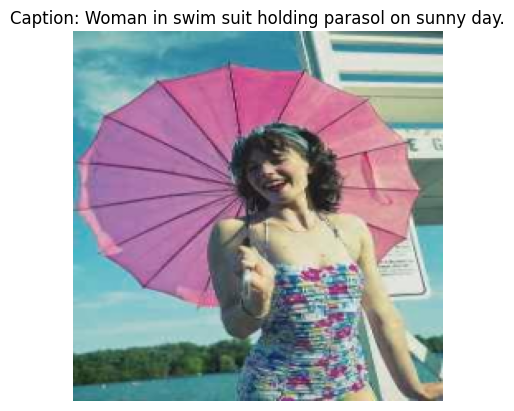

Decoded Label: [1]
Binary Label: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [342]:
example_img, example_caption, example_label = train_dataset[0]  #test id 
show_example(example_img, example_caption, example_label)

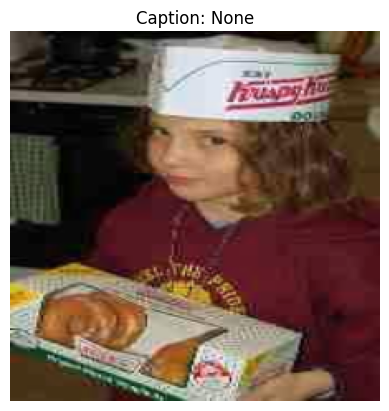

In [350]:

example_img, example_caption = test_dataset[0] 

def show_test_example(img, caption):
    img = denorm(img).permute(1, 2, 0).clamp(0, 1)  
    plt.imshow(img)
    plt.axis('off') 
    plt.title(f"Caption: {caption}")
    plt.show()
    
show_test_example(example_img, example_caption)


In [360]:
# Model 

import torch
import torch.nn as nn
from torchvision.models import efficientnet_b4

# Multi-Label Model with EfficientNet backbone
class CustomEfficientNetModel(nn.Module):
    def __init__(self, num_classes=18):
        super(CustomEfficientNetModel, self).__init__()
        
        # pre-trained EfficientNet backbone
        backbone = efficientnet_b4(weights='IMAGENET1K_V1')
        self.features = nn.Sequential(*list(backbone.children())[:-2]) 
        
        # Adaptive pooling
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        # Fully connected classifier
        self.classifier = nn.Sequential(
            nn.Linear(1792 * 7 * 7, 64),  # 1792 channels for EfficientNet-B4
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes),
        )
    
    def forward(self, x):
        # Feature extraction
        x = self.features(x)
        # Adaptive pooling
        x = self.avgpool(x)
        # Flatten the feature map
        x = torch.flatten(x, 1)
        # Classification
        x = self.classifier(x)
        return torch.sigmoid(x) 




In [361]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomEfficientNetModel(num_classes=18).to(device)

#dummy input
dummy_input = torch.randn(1, 3, 224, 224).to(device)  
output = model(dummy_input)

print(f"Output Shape: {output.shape}") 

Output Shape: torch.Size([1, 18])


In [362]:
print(f"Model Output: {output}") # Predicted probabiltiies for each label


Model Output: tensor([[0.5383, 0.4203, 0.5648, 0.5116, 0.4630, 0.4711, 0.5496, 0.4614, 0.4971,
         0.4696, 0.5953, 0.4689, 0.4755, 0.4123, 0.5233, 0.5764, 0.5538, 0.4298]],
       grad_fn=<SigmoidBackward0>)


In [364]:

if torch.cuda.is_available():
    torch.cuda.empty_cache() 

# Loss Function
loss_fn = nn.BCELoss()  

# Define the Pre-Trained Model
imgmodel = efficientnet_b4(weights="IMAGENET1K_V1")

# Update Classifier Head for Multi-Label Classification
imgmodel.classifier = nn.Sequential(
    nn.Linear(imgmodel.classifier[1].in_features, 128),  
    nn.ReLU(),                                          
    nn.Dropout(0.3),                                    
    nn.Linear(128, 18),                                
    nn.Sigmoid()                                        
)

# Transfer Model to Device
model = imgmodel.to(device)

# Optimizer: AdamW for Better Weight Decay
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-5)  # Use AdamW


In [367]:
dummy_input = torch.randn(1, 3, 224, 224).to(device)
model.eval()  
with torch.no_grad():  
    output = model(dummy_input)
    
print(f"Output Shape: {output.shape}")  #
print(f"Model Output (Probabilities): {output}")


Output Shape: torch.Size([1, 18])
Model Output (Probabilities): tensor([[0.4718, 0.4864, 0.5210, 0.5011, 0.5014, 0.5067, 0.5069, 0.4947, 0.5066,
         0.4936, 0.4942, 0.5035, 0.5090, 0.4940, 0.4959, 0.4842, 0.5223, 0.4867]])


In [366]:
# most values around 0.5 because model not trained properly yet